# Multiclass Text Classification - Keras, LSTM

## Import Modules

In [67]:
import pandas as pd
import numpy as np
import random
import pickle

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Mount Google Drive

In [32]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Hyperparameters

In [0]:
# Hyperparamters
epochs = 10
emb_dim = 128
batch_size = 256

## Load News Aggregator Dataset

In [0]:
# load News Aggregator dataset to pandas dataframe
df_news = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset/newsCorpora.csv', sep='\t', names=['ID', 'Title', 'URL', 'Publisher', 'Category', 'Story', 'Hostname', 'Timestamp'])
df_news = df_news[['Title', 'Category']]

# Shuffling dataset
shuffled = df_news.reindex(np.random.permutation(df_news.index))

# balance the dataset
num_of_categories = 45000
b = shuffled[shuffled['Category'] == 'b'][:num_of_categories]
t = shuffled[shuffled['Category'] == 'e'][:num_of_categories]
e = shuffled[shuffled['Category'] == 'm'][:num_of_categories]
m = shuffled[shuffled['Category'] == 't'][:num_of_categories]

# Concatenate and reshuffle
concated = pd.concat([b, e, t, m], ignore_index=True)
concated = concated.reindex(np.random.permutation(concated.index))

In [34]:
# One-hot-encode
concated['Label'] = 0

concated.loc[concated['Category'] == 'b', 'Label'] = 0
concated.loc[concated['Category'] == 'e', 'Label'] = 1
concated.loc[concated['Category'] == 'm', 'Label'] = 2
concated.loc[concated['Category'] == 't', 'Label'] = 3
print(concated.iloc[:10])

labels = to_categorical(concated['Label'], num_classes=4)
print(labels[:10])

                                                    Title Category  Label
24347   Australians say latest objects need to be insp...        b      0
111267  Angelina Jolie talks about Maleficent, her mas...        e      1
130565  Friends Were Deeply Concerned About L'Wren Sco...        e      1
140018  Move over Google! Amazon reportedly close to a...        t      3
122046  Batman: Arkham Knight Delayed Into 2015, But T...        e      1
13038   China could set economic weather despite US Fe...        b      0
4823    BoE Chief Says Interest Rates Could Rise Soone...        b      0
31456   Weekly Jobless Claims Come in Lower but Look Flat        b      0
146057    10 Things In Tech You Need To Know This Morning        t      3
31897   US STOCKS SNAPSHOT-Wall St ends down; S&P has ...        b      0
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


## Text Processing

-  using helper function modified from https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text

In [0]:
# Helper function to clean data

def text_to_wordlist(text, remove_stopwords=False, stem_words=False, lem_words=False):
    '''
    Clean the text, with the option to remove stopwords and to stem words.
    
    Convert words to lower case and split them
    '''
    
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = PorterStemmer()
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
        
    # Optionally, lemmatize words to their base words
    if lem_words:
      text = text.split()
      lem = WordNetLemmatizer()
      lemmed_words = [lem.lemmatize(word) for word in text]
      text = " ".join(lemmed_words)
    
    # Return a list of words
    return(text)

In [37]:
# Training and testing dataset
n_most_common_words = 38000
max_len = 130

X_text = concated['Title']
X_text_clean = []
for idx, text in X_text.iteritems():
  out1 = text_to_wordlist(text, remove_stopwords=True, lem_words=True)
  X_text_clean.append(out1)
  
tokenizer = Tokenizer(num_words=n_most_common_words)
tokenizer.fit_on_texts(X_text_clean)
sequences = tokenizer.texts_to_sequences(X_text_clean)
word_index = tokenizer.word_index

print('Found unique {} words'.format(len(word_index)))

X = pad_sequences(sequences, maxlen=max_len, padding='pre')

Found unique 36084 words


## Training and Testing Dataset

In [38]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=88)

print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(135000, 130) (45000, 130)
(135000, 4) (45000, 4)


## Build LSTM Model

In [39]:
# LSTM model
first = Input(shape=(130,)) 
embedding1 = Embedding(n_most_common_words, emb_dim)(first)
drop1 = SpatialDropout1D(0.7)(embedding1)
lstm1 = LSTM(64, dropout=0.7, recurrent_dropout=0.7)(drop1)
dense1 = Dense(4, activation='softmax')(lstm1)

# Build model
model = Model(inputs=first, outputs=dense1)

# Model summmary
model.summary()

# Model compile
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Model plot graph
plot_model(model, to_file='/content/gdrive/My Drive/Colab Notebooks/LSTM1.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 130)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 130, 128)          4864000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 4,913,668
Trainable params: 4,913,668
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Model fit
from keras.callbacks import EarlyStopping
history = model.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=2, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

Train on 108000 samples, validate on 27000 samples
Epoch 1/10
 - 138s - loss: 0.8041 - acc: 0.6738 - val_loss: 0.3023 - val_acc: 0.8983
Epoch 2/10
 - 137s - loss: 0.3528 - acc: 0.8791 - val_loss: 0.2322 - val_acc: 0.9224
Epoch 3/10
 - 137s - loss: 0.2727 - acc: 0.9093 - val_loss: 0.2092 - val_acc: 0.9303
Epoch 4/10
 - 137s - loss: 0.2311 - acc: 0.9235 - val_loss: 0.1986 - val_acc: 0.9339
Epoch 5/10
 - 137s - loss: 0.2100 - acc: 0.9307 - val_loss: 0.1929 - val_acc: 0.9356
Epoch 6/10
 - 136s - loss: 0.1927 - acc: 0.9369 - val_loss: 0.1896 - val_acc: 0.9363
Epoch 7/10
 - 136s - loss: 0.1771 - acc: 0.9408 - val_loss: 0.1889 - val_acc: 0.9368
Epoch 8/10
 - 136s - loss: 0.1664 - acc: 0.9448 - val_loss: 0.1884 - val_acc: 0.9378
Epoch 9/10
 - 137s - loss: 0.1586 - acc: 0.9472 - val_loss: 0.1872 - val_acc: 0.9388
Epoch 10/10
 - 136s - loss: 0.1527 - acc: 0.9496 - val_loss: 0.1896 - val_acc: 0.9391


## Plot Model History

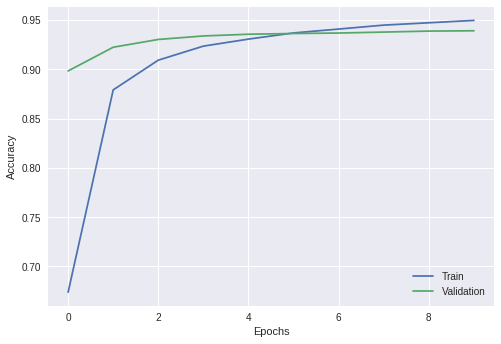

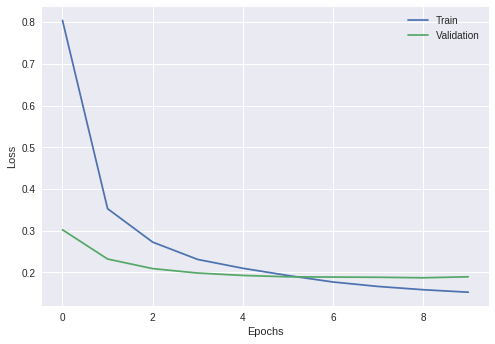

In [68]:
# Plotting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluate the Model

In [44]:
test_acc = model.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_acc[0], test_acc[1]))

45000/45000 [==============================] - 158s 4ms/step
Test set
  Loss: 0.185
  Accuracy: 0.941


## Model Prediction

In [66]:
# Model prediction
text = ['The singer has been living in a state of pure bliss ever since the Pirates of the Caribbean star popped the question on Valentine\'s Day.']
seq = tokenizer.texts_to_sequences(text)
text_padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(text_padded)
labels = ['business', 'entertainment', 'science-and-technology', 'health']
print(pred, labels[np.argmax(pred)])
print('The predicted label is \'{}\''.format(labels[np.argmax(pred)]))

[[4.6725490e-04 9.9918753e-01 1.6938722e-04 1.7574341e-04]] entertainment
The predicted label is 'entertainment'


## Save Model

In [0]:
# Save keras model
model.save('/content/gdrive/My Drive/Colab Notebooks/models/multiclass_text_classifier_032719.h5')

# Saving tokenizer to file 
with open('/content/gdrive/My Drive/Colab Notebooks/models/multiclass_text_classifier_tokenizer_032719.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)